In this notebook, we try to forecast demand for a particular item using other columns like warehouse and category
<br>
<br>
First we import our packages including two classifiers we will apply on the data set

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import preprocessing


Now we read in our data

In [2]:
dfProducts = pd.read_csv('./Data/HistoricalProductDemand.csv', index_col='Date', parse_dates=[3])
dfProducts = dfProducts.dropna()
dfProducts.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100
2012-01-19,Product_0979,Whse_J,Category_028,500
2012-02-03,Product_0979,Whse_J,Category_028,500
2012-02-09,Product_0979,Whse_J,Category_028,500
2012-03-02,Product_0979,Whse_J,Category_028,500


Now sort it by date

In [3]:
dfProducts = dfProducts.sort_values(by=['Date']).reset_index()
dfProducts.head()

,Date,Product_Code,Warehouse,Product_Category,Order_Demand
0,2011-01-08,Product_0965,Whse_A,Category_006,2
1,2011-05-31,Product_1724,Whse_A,Category_003,108
2,2011-06-24,Product_1521,Whse_S,Category_019,85000
3,2011-06-24,Product_1521,Whse_S,Category_019,7000
4,2011-09-02,Product_1507,Whse_C,Category_019,1250


We clean the data by removing the prefixes in the data to make it usable

In [4]:
#remove 'Product_' from Product_Code by splicing and cast to int
dfProducts['Product_Code'] = dfProducts['Product_Code'].str[8:].astype(int)

#remove 'Category_' from Product_Category
dfProducts['Product_Category'] = dfProducts['Product_Category'].str[9:].astype(int)

dfProducts.head()

,Date,Product_Code,Warehouse,Product_Category,Order_Demand
0,2011-01-08,965,Whse_A,6,2
1,2011-05-31,1724,Whse_A,3,108
2,2011-06-24,1521,Whse_S,19,85000
3,2011-06-24,1521,Whse_S,19,7000
4,2011-09-02,1507,Whse_C,19,1250


Currently, negative demand is denoted with parenthesis. To make this usable, we will convert to integer

In [5]:
#replace parenthesis with negative sign so not object
dfProducts['Order_Demand'].replace('[(]', '-', inplace=True, regex=True)
dfProducts['Order_Demand'].replace('[)]', '', inplace=True, regex=True)
dfProducts['Order_Demand'] = dfProducts['Order_Demand'].astype(int)

We'd like to focus on a single product to forecast its demand

In [6]:
#drop all rows except product 979
dfProducts = dfProducts[dfProducts.Product_Code == 979]

dfProducts.info()
dfProducts.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3928 entries, 795 to 1048104
Data columns (total 5 columns):
Date                3889 non-null datetime64[ns]
Product_Code        3928 non-null int32
Warehouse           3928 non-null object
Product_Category    3928 non-null int32
Order_Demand        3928 non-null int32
dtypes: datetime64[ns](1), int32(3), object(1)
memory usage: 138.1+ KB


,Date,Product_Code,Warehouse,Product_Category,Order_Demand
795,2012-01-03,979,Whse_A,28,2000
1236,2012-01-05,979,Whse_J,28,100
1306,2012-01-05,979,Whse_J,28,600
1439,2012-01-05,979,Whse_J,28,500
1652,2012-01-05,979,Whse_A,28,500


Let's take a look at the demand for product 979 over time

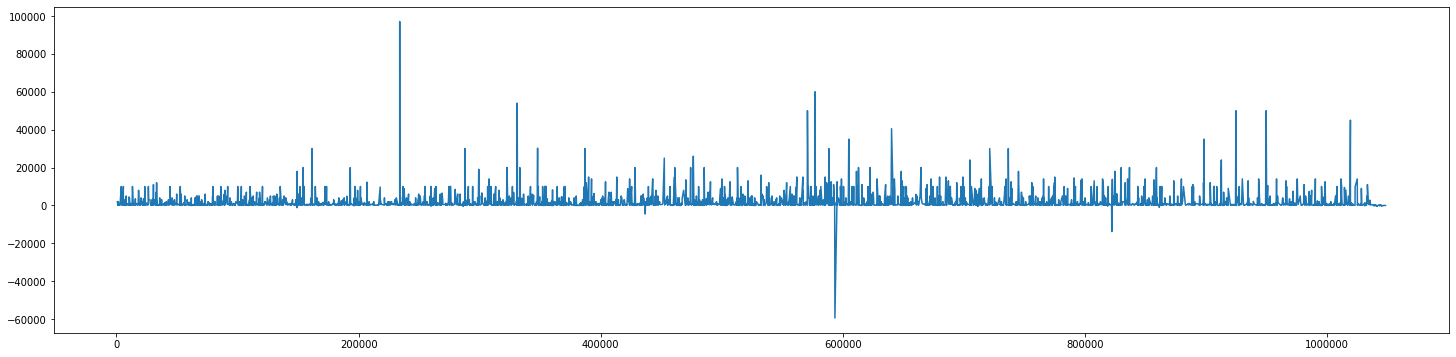

In [7]:
plt.figure(figsize = (25,6))
plt.plot(dfProducts.index, dfProducts['Order_Demand']);

We see clear negative outliers. We should exclude these.

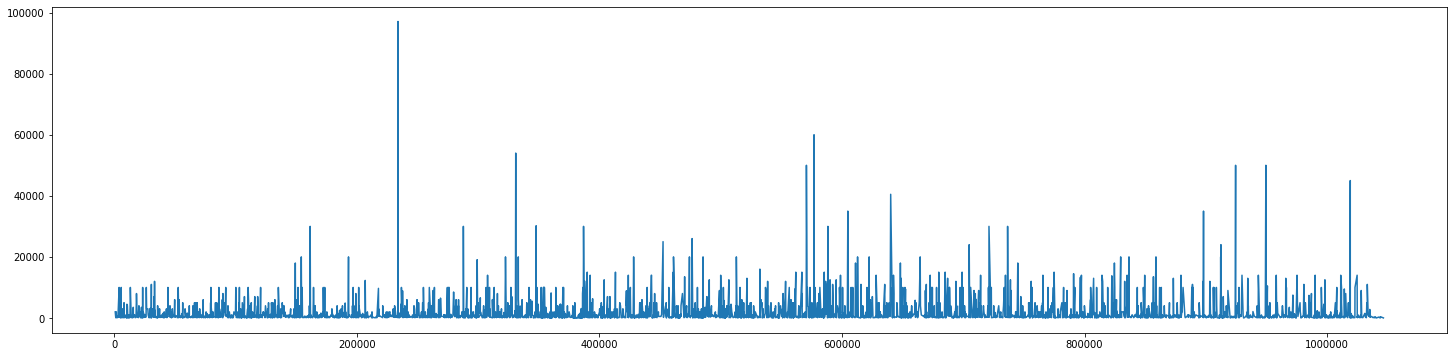

In [8]:
dfProducts = dfProducts[dfProducts.Order_Demand >= 0]
plt.figure(figsize = (25,6))
plt.plot(dfProducts.index, dfProducts['Order_Demand']);

Now label encoding has to be done to make the data usable by the models

In [9]:
#label encode
labelEncoder = preprocessing.LabelEncoder()
#overwrite Warehouse with its label encoding
dfProducts['Warehouse'] = labelEncoder.fit_transform(dfProducts['Warehouse'])
dfProducts.head()

,Date,Product_Code,Warehouse,Product_Category,Order_Demand
795,2012-01-03,979,0,28,2000
1236,2012-01-05,979,1,28,100
1306,2012-01-05,979,1,28,600
1439,2012-01-05,979,1,28,500
1652,2012-01-05,979,0,28,500


Now we will try to predict player using the other columns

In [10]:
indepVars = dfProducts[['Product_Code', 'Warehouse', 'Product_Category']]
depVars = dfProducts['Order_Demand']

In [11]:
from sklearn.model_selection import train_test_split
# split into training set and test set
# train on 70 percent of the data and test on 30
X_train, X_test, Y_train, Y_test = train_test_split(indepVars, depVars, test_size=0.3, random_state=1)

First we will try to use Gradient Boosting

In [12]:
regressor = GradientBoostingRegressor()
regressor = regressor.fit(X_train, Y_train)
trainGradientBoosting = r2_score(Y_train, regressor.predict(X_train), multioutput='variance_weighted')
predictionGradientBoosting = r2_score(Y_test, regressor.predict(X_test), multioutput='variance_weighted')

print(trainGradientBoosting)
print(predictionGradientBoosting)

0.020298749673775873
0.024045443985767467


The results aren't great but they are somewhat respectable<br><br>
Lets try linear regression and compare

In [13]:
regressor = LinearRegression()
regressor = regressor.fit(X_train, Y_train)
trainLinear = r2_score(Y_train, regressor.predict(X_train), multioutput='variance_weighted')
predictionLinear = r2_score(Y_test, regressor.predict(X_test), multioutput='variance_weighted')

print(trainLinear)
print(predictionLinear)

0.004584831725828575
0.009076012010520884


Because linear regression assumes that the columns are indepent, the performance here is extremely poor